### Import packages and Define utility functions

In [1]:
import numpy as np
import torch 
import pandas as pd
import matplotlib.pyplot as plt


### Load from previous step

In [2]:
# Read CSV file into a pandas DataFrame
df_clean = pd.read_csv('df_clean.csv', converters={'id': str, 
                                                        'member_id': str})    
df_clean.head()

,id,member_id,loan_amnt,emp_length,home_ownership,annual_inc,desc,purpose,dti,inq_last_6mths,...,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,revol_util_nb_fixed,loan_amnt_log,annual_inc_log,total_bc_limit_log,tot_hi_cred_lim_log,tot_cur_bal_log
0,10000001,11983056,7550,3 years,RENT,28000.0,NaN,debt_consolidation,8.40,0.0,...,4000.0,41.792473,3828.953801,5759.0,9600.0,8.929303,10.239960,8.294050,8.250347,8.658519
1,10000002,12002921,27050,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,22.87,0.0,...,35700.0,41.792473,34359.940730,114834.0,5390.0,10.205442,10.915088,10.482906,10.444647,11.651243
2,10000003,11983096,12000,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,4.62,1.0,...,18100.0,41.792473,16416.617760,7137.0,1590.0,9.392662,11.002100,9.803667,9.706049,8.873048
3,10000004,12003142,28000,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,18.55,1.0,...,42200.0,41.792473,38014.149760,799592.0,6710.0,10.239960,12.691580,10.650176,10.545714,13.591857
4,10000005,11993233,12000,10+ years,RENT,40000.0,NaN,debt_consolidation,16.94,0.0,...,7000.0,53.000000,6471.462236,13605.0,7960.0,9.392662,10.596635,8.853665,8.775157,9.518193


In [3]:
df.dtypes

NameError: name 'df' is not defined

In [ ]:
# "term" should be numeric
df.term.value_counts()

In [ ]:
# fix "term"
df['term_nb'] = np.where(df['term'].notnull() & ~df['term'].isna(), 
                         pd.to_numeric(df['term'].str[0:3], errors='coerce'), 
                         np.nan
                        )
df.term_nb.dtype, df.term_nb.value_counts()

In [ ]:
# "int_rate", "revol_util" should be float. They are read in as characters due to the "%".
df['int_rate'].value_counts(), df['revol_util'].value_counts() 

In [ ]:
# fix "int_rate", "revol_util"
df['int_rate_nb'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
df['revol_util_nb'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
df['int_rate_nb'].dtype, df['int_rate_nb'][0: 5], df['revol_util_nb'].dtype, df['revol_util_nb'][0: 5]

In [ ]:
# "emp_length" could be numeric or character depending on the data. Let's take a look first.
df['emp_length'].value_counts()

In [ ]:
# no need to fix at this moment. In the modeling phase, values need to be encoded and/or binned then encoded.

In [ ]:
# duplicate rows
def rm_dup_rows(df_in):
    df = df_in.copy()
    dup_count = len(df) - len(df.drop_duplicates())
    print(f"There are no duplicate records. - {dup_count == 0}")
    
    if not len(df) == len(df.drop_duplicates()):
        df.drop_duplicates(inplace=True)
        print(f"{dup_count} of duplicate records were removed.")
    else:
        print("No duplicate rows detected.")
    print(f"The dataset has {len(df)} rows.")
    return df

df_dedup = rm_dup_rows(df)

In [ ]:
# duplicate IDs - "True" tells that values in columns "id" are all unique, which is as expected.
df_dedup.id.nunique() == len(df_dedup) 

In [ ]:
# "application_approved_flag" could be useless because all records should be approved loans. to confirm:
df_dedup['application_approved_flag'].value_counts()

In [ ]:
# drop column "application_approved_flag", "term", "int_rate", "revol_util"
df_dedup.drop(['application_approved_flag', "term", "int_rate", "revol_util"], axis=1, inplace=True)

In [ ]:
df_dedup.describe()

In [ ]:
(df_dedup.describe().loc['count'] - len(df_dedup)) / len(df_dedup)

In [ ]:
df_dedup_2 = df_dedup.loc[df_dedup['bad_flag'].notnull()].copy()
df_dedup_2.describe()

In [ ]:
# 'bad_flag'
df_dedup_2['bad_flag'].value_counts(), df_dedup_2['bad_flag'].sum() / len(df_dedup_2['bad_flag'])

In [ ]:
create_box_plot(df_dedup_2)

In [ ]:
dynamic_boxplot(df_dedup_clean['annual_inc'].dropna())

In [ ]:
plt.hist(df_dedup_clean['annual_inc'], bins=100)

In [ ]:
IQR = df_dedup_2['annual_inc'].quantile(0.75) - df_dedup_2['annual_inc'].quantile(0.25)
upper_band = df_dedup_2['annual_inc'].quantile(0.75) + 1.5 * IQR
print(f"There are {sum(df_dedup_2['annual_inc'] > upper_band)} of outliers in 'annual_inc'. ")
print(f"# of $1M + {sum(df_dedup_2['annual_inc'] > 1000000)}")

In [ ]:
# Be definition, utilization variables including 'bc_util' and 'revol_util_nb' should indicate a percentage between 0 and 100%.
print(f"# of records where 'bc_util' or 'revol_util_nb' is out of boundary is {sum(df_dedup_2['bc_util'] > 100), sum(df_dedup_2['revol_util_nb'] > 1)}, respectively.")

In [ ]:
# Fix utilization rate
df_dedup_2['bc_util_fixed'] = np.where(df_dedup_2['bc_util'] > 100, 100, df_dedup_2['bc_util'])
df_dedup_2['revol_util_nb_fixed'] = np.where(df_dedup_2['revol_util_nb'] > 1, 100, df_dedup_2['bc_util'] * 100)

In [ ]:
# remind myself of variables having missing values, and the distributions among event v.s non-event
for c in df_dedup_2.columns:
    if df_dedup_2[c].isnull().sum() > 0:
        print(c, df_dedup_2.loc[df_dedup_2[c].isnull(), 'bad_flag'].value_counts())

In [ ]:
# Fill Missing values in "emp_length" with 'NONE' as a string
df_dedup_2['emp_length'] = df_dedup_2['emp_length'].fillna('NONE')
df_dedup_2['emp_length'].value_counts()

In [ ]:
# Fill missing values of numeric variables with their corresponding mean
c_lst = ['percent_bc_gt_75', 'bc_util_fixed', 'mths_since_recent_inq', 'total_bc_limit', 'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal', 'revol_util_nb_fixed']
## create a new dataframe to house the cleaned data
carry_cols = [c for c in df_dedup_2.columns if (c not in c_lst) & (c not in ['bc_util', 'revol_util_nb'])]
df_clean = df_dedup_2[carry_cols].copy()

for c in c_lst:
    print(f"Missing values in '{c}' is imputed by its mean.")
    df_clean[c] = df_dedup_2[c].fillna(df_dedup_2[c].mean())

In [ ]:
df_clean.describe()

In [ ]:
character_columns = df_clean.select_dtypes(include='object').columns
for c in character_columns:
    print(f"# of Missing values in {c}: {df_clean[c].isnull().sum() / 1}")

Findings:
1. 

### 4. Explore the dataset - bivariate analysis

#### 4.1 Let's create some transformation first.
Findings / Summary:
* Create log transformation of large dollar amount columns. It helps to reduce the weight of outliers.

In [5]:
# Create log transformation
def create_log_var(data, vars):
    df = data.copy()
    for v in vars:
        df[v + '_log'] = np.where(df[v] > 0, np.log(df[v]), 0)
        print(f"Created {v}_log")
    return df

vars = ['loan_amnt', 'annual_inc', 'total_bc_limit', 'tot_hi_cred_lim', 'tot_cur_bal']
df_clean = create_log_var(df_clean, vars)

Created loan_amnt_log
Created annual_inc_log
Created total_bc_limit_log
Created tot_hi_cred_lim_log
Created tot_cur_bal_log


#### 4.2 Examine correlation between each pair of variables.
Findings / Summary:
* Looking at pair-wise correlation of all numeric variables, multicollinearity may not be a big concern with only a few pairs having high correlation
    * internal_score and loan_amnt_log
    * percent_bc_gt_75, revol_util_nb_fixed and bc_util_fixed
    * correlation between revol_util_nb_fixed and bc_util_fixed is as high as 0.99.

In [6]:
incl_cols = [ 
       'dti', 'inq_last_6mths',
       'internal_score', 'bad_flag', 'term_nb', 'int_rate_nb',
       'percent_bc_gt_75', 'bc_util_fixed', 'mths_since_recent_inq',
       'mths_since_last_major_derog', 
       'revol_util_nb_fixed', 'loan_amnt_log', 'annual_inc_log',
       'total_bc_limit_log', 'tot_hi_cred_lim_log', 'tot_cur_bal_log']

corr = df_clean[incl_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,dti,inq_last_6mths,internal_score,bad_flag,term_nb,int_rate_nb,percent_bc_gt_75,bc_util_fixed,mths_since_recent_inq,mths_since_last_major_derog,revol_util_nb_fixed,loan_amnt_log,annual_inc_log,total_bc_limit_log,tot_hi_cred_lim_log,tot_cur_bal_log
dti,1.000000,0.011619,0.044566,0.039879,0.083453,0.147578,0.188125,0.206684,0.000952,0.019239,0.205469,0.051405,-0.216860,0.049501,0.049566,0.122158
inq_last_6mths,0.011619,1.000000,0.019807,0.059380,0.040899,0.241492,-0.078224,-0.081261,-0.640133,-0.002095,-0.079205,0.008902,0.104708,-0.003537,-0.003458,0.097641
internal_score,0.044566,0.019807,1.000000,0.009110,0.440817,0.182788,0.007224,0.041243,-0.000088,-0.031756,0.039973,0.927234,0.502930,0.312313,0.312193,0.305679
bad_flag,0.039879,0.059380,0.009110,1.000000,0.038482,0.121427,0.046743,0.040724,-0.048175,-0.001033,0.040352,0.004951,-0.059127,-0.042862,-0.042741,-0.011728
term_nb,0.083453,0.040899,0.440817,0.038482,1.000000,0.461320,0.046341,0.051665,-0.024888,-0.013298,0.050118,0.407910,0.150314,0.081777,0.081733,0.151345
int_rate_nb,0.147578,0.241492,0.182788,0.121427,0.461320,1.000000,0.353777,0.374629,-0.209500,-0.004483,0.368633,0.112633,-0.035387,-0.217238,-0.216865,-0.134533
percent_bc_gt_75,0.188125,-0.078224,0.007224,0.046743,0.046341,0.353777,1.000000,0.831549,0.055076,0.016368,0.822065,0.005730,-0.041244,-0.151893,-0.151789,0.024298
bc_util_fixed,0.206684,-0.081261,0.041243,0.040724,0.051665,0.374629,0.831549,1.000000,0.054730,0.013673,0.989724,0.044091,-0.013224,-0.163088,-0.162952,0.042758
mths_since_recent_inq,0.000952,-0.640133,-0.000088,-0.048175,-0.024888,-0.209500,0.055076,0.054730,1.000000,-0.000422,0.052566,0.007635,-0.059670,0.012973,0.012780,-0.060734
mths_since_last_major_derog,0.019239,-0.002095,-0.031756,-0.001033,-0.013298,-0.004483,0.016368,0.013673,-0.000422,1.000000,0.013713,-0.027689,-0.045252,-0.005383,-0.005333,-0.037192


#### 4.3 Distribution of bad_flag sliced by different variables.
Findings / Summary:
* Telling from the histograms, it looks events are evenly distributed among bins of each variable. No obviously correlation can be identified between 'bad_flag' and any other variables. We'll leave it to the algorithm in the following steps. 

In [7]:
def create_stacked_hist(data, variables, group_by_column, bins):
    df = data.copy()
    rows = len(variables) // 4 if len(variables) % 4 == 0 else len(variables) // 4 + 1
    fig, axes = plt.subplots(rows, 4, figsize=(15, 10))
           
    for ax, var in zip(axes.flatten(), variables):
        column_to_plot = var
        # Group the data by the specified column
        grouped_data = df.groupby(group_by_column)[column_to_plot]
    
        # Create a list of data for each group
        data_to_plot = [group for name, group in grouped_data]
    
        # Create the stacked histogram
        ax.hist(data_to_plot, bins=bins, stacked=True, label=grouped_data.groups.keys())
        ax.set_title(var)

    plt.tight_layout()
    plt.show()

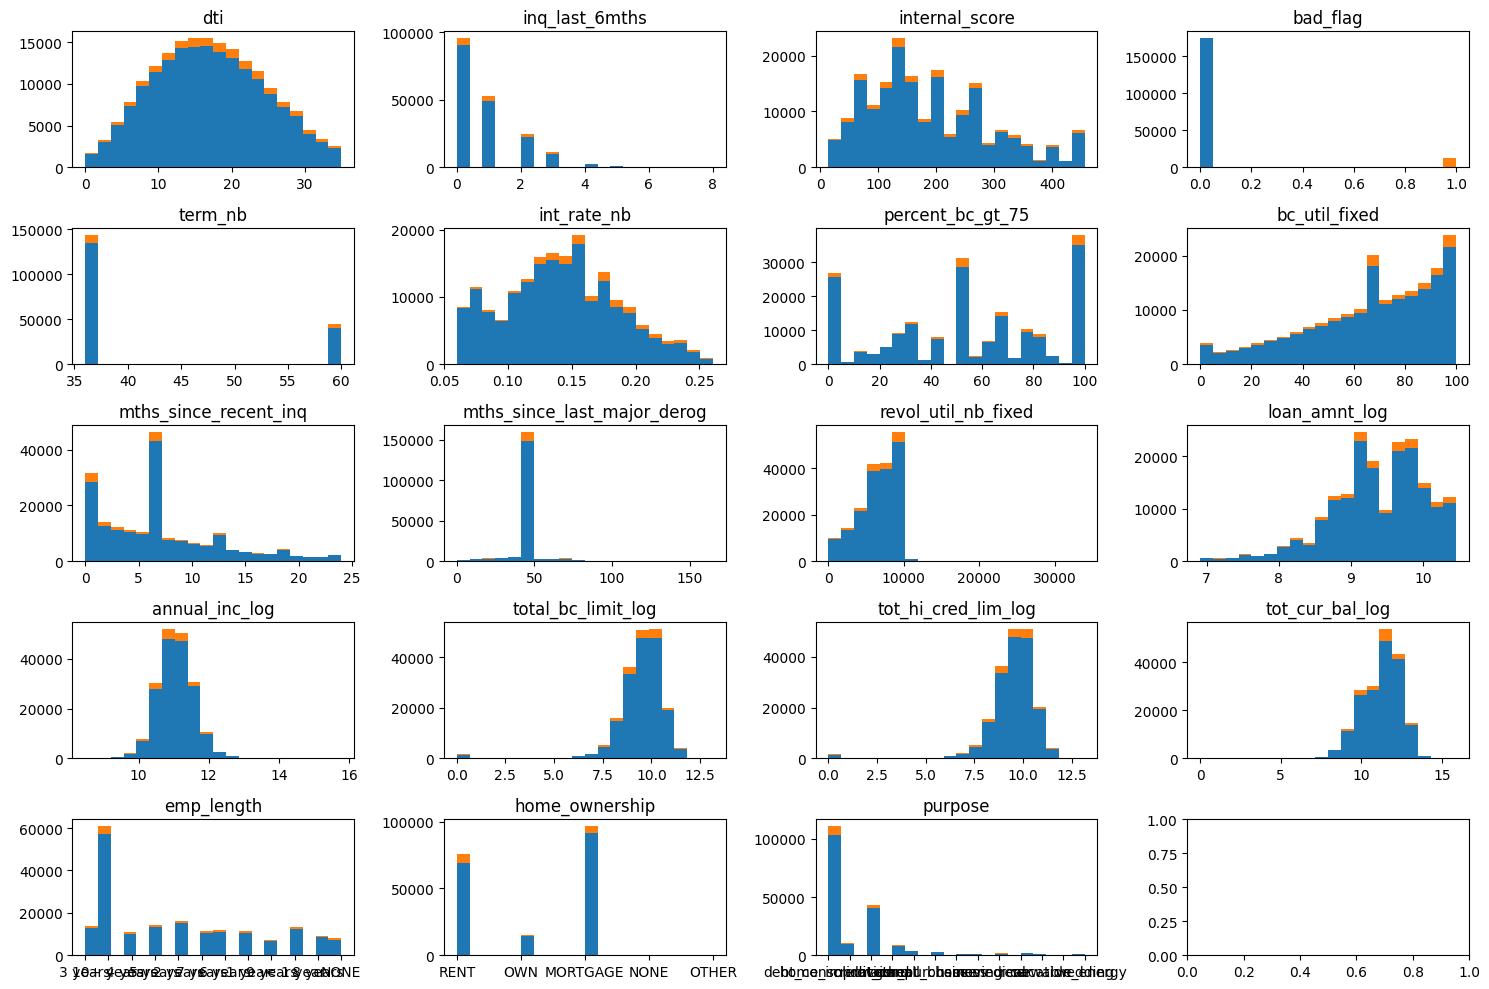

In [8]:
# Stacked Histograms
bins = 20
create_stacked_hist(df_clean, incl_cols + ['emp_length', 'home_ownership',  'purpose'], 'bad_flag', bins)

### 5. Output cleaned dataset for modeling

In [9]:
df_clean.to_csv('clean_training_data.csv', index=False)